In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ml-starter/sample_submission.csv
/kaggle/input/ml-starter/sale_data_train.csv


In [2]:
data = pd.read_csv('/kaggle/input/ml-starter/sale_data_train.csv')
data.head()

,InvoiceDate,TotalSales
0,2010-12-01,12904.25
1,2010-12-02,6815.68
2,2010-12-03,11114.09
3,2010-12-05,7893.17
4,2010-12-06,17678.78


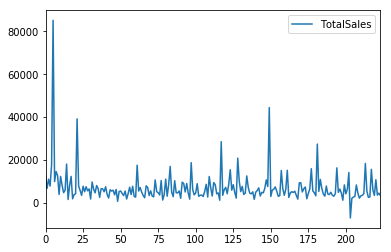

In [3]:
import matplotlib.pyplot as plt
data.plot()
plt.show()

In [4]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate, format = '%Y-%M-%d').dt.date
data.InvoiceDate.dtype

dtype('O')

Most of the TSA has assumption that the data is stationary. Stationarity is important because, in its absence, a model describing the data will vary in accuracy at different time points. As such, stationarity is required for sample statistics such as means, variances, and correlations to accurately describe the data at all time points of interest.

**There are many methods to check whether a time series is stationary or non-stationary.**
1. Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
2. Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
3. Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

We will do statistical test to determine stationarity of our dataset.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

**p-value > 0.05:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

If the absolute statistic is less than or equal to the  absolute critical value, we fail to reject the null hypothesis (e.g. no effect). Otherwise it is rejected. We can summarize this interpretation as follows: Test Statistic <= Critical Value: Fail to reject the null hypothesis of the statistical test.

In [5]:
from statsmodels.tsa.stattools import adfuller
X = data.TotalSales.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.337045
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574


**Interpretation:** <br/>
**From p-value:** <br/>
As p-value less than 0.05 so we rejected the null hypothesis (H0), the data does not have a unit root and is stationary. As p value is less than 0.01 it is true at 1% level of significance.

**From critical value:** <br/>
As 14.337045 is greater than 3.460 so we can reject the null hypothesis at 1%. so the data is stationary.

We may also use KPSS test if we see we have a deterministic trend in our dataset.

For testing purpose we need to create a test/validation set.

In [6]:
train = data[:180]
test = data[181:]
print(train.shape)
print(test.shape)

(180, 2)
(43, 2)


Technique 1: **Simple Moving Average**

Forecasting technique which uses window of time period for calculating the average is called Moving Average technique. Calculation of the moving average involves what is sometimes called a “sliding window” of size n.

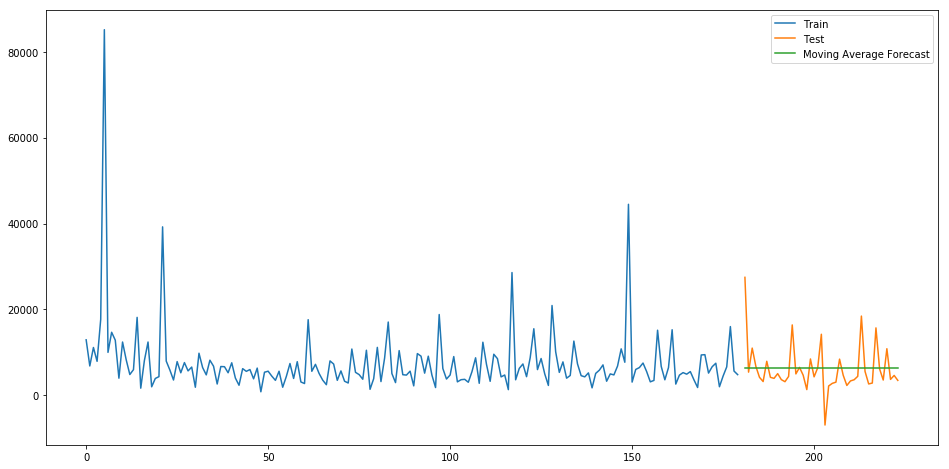

In [7]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['TotalSales'].rolling(20).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['TotalSales'], label='Train')
plt.plot(test['TotalSales'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.TotalSales, y_hat_avg.moving_avg_forecast))
print('RMSE Moving Avg:',rms)

RMSE Moving Avg: 5476.3323927436495


In [9]:
sub = pd.read_csv('/kaggle/input/ml-starter/sample_submission.csv')
print(sub.shape)

(80, 2)


In [10]:
y_hat_avg = sub.copy()
y_hat_avg['moving_avg_forecast'] = data['TotalSales'].rolling(5).mean().iloc[-1]
sub['TotalSales'] = y_hat_avg['moving_avg_forecast']
sub.to_csv('submission.csv',index = False)
sub.head()

,InvoiceDate,TotalSales
0,2011-09-08,5224.696
1,2011-09-09,5224.696
2,2011-09-11,5224.696
3,2011-09-12,5224.696
4,2011-09-13,5224.696


Technique 2: **Simple Exponential Smothing (SES)**

Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

SES has a smoothing parameter alpha (α), where 0≤ α ≤1.

RMSE Moving Avg: 5469.400631551746


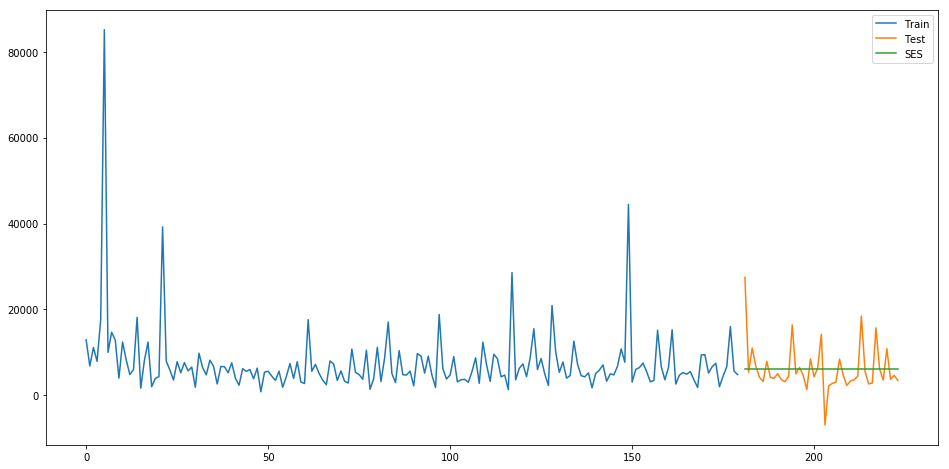

In [11]:
from statsmodels.tsa.api import SimpleExpSmoothing
y_ses = test.copy()
ses_model = SimpleExpSmoothing(np.asarray(train['TotalSales'])).fit(smoothing_level=0.6, optimized=False)
y_ses['SES'] = ses_model.forecast(len(test))

rms = sqrt(mean_squared_error(test.TotalSales, y_ses.SES))
print('RMSE Moving Avg:',rms)

plt.figure(figsize=(16,8))
plt.plot(train['TotalSales'], label='Train')
plt.plot(test['TotalSales'], label='Test')
plt.plot(y_ses['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [12]:
sub['TotalSales'] = ses_model.forecast(len(sub))
sub.to_csv('submission_ses.csv',index = False)
sub.head()

,InvoiceDate,TotalSales
0,2011-09-08,6125.844078
1,2011-09-09,6125.844078
2,2011-09-11,6125.844078
3,2011-09-12,6125.844078
4,2011-09-13,6125.844078


Technique 3: **Autoregressive Integrated Moving average (ARIMA):

ARIMA, short for 'AutoRegressive Integrated Moving Average', is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values. While exponential smoothing models were based on a description of trend and seasonality in the data, ARIMA models aim to describe the correlations in the data with each other.

ARIMA model has 3 terms/order p,d,q


p is the number of autoregressive terms,
d is the number of nonseasonal differences needed for stationarity, and
q is the number of lagged forecast errors in the prediction equation.

In [13]:
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(train.TotalSales, order=(0, 0, 0)).fit(disp=0)
print(model_arima.summary())

                              ARMA Model Results                              
Dep. Variable:             TotalSales   No. Observations:                  180
Model:                     ARMA(0, 0)   Log Likelihood               -1873.191
Method:                           css   S.D. of innovations           8003.859
Date:                Wed, 11 Dec 2019   AIC                           3750.382
Time:                        13:22:11   BIC                           3756.768
Sample:                             0   HQIC                          3752.972
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7420.2381    596.572     12.438      0.000    6250.978    8589.499


RMSE Moving Avg for ARIMA: 5626.90070946452


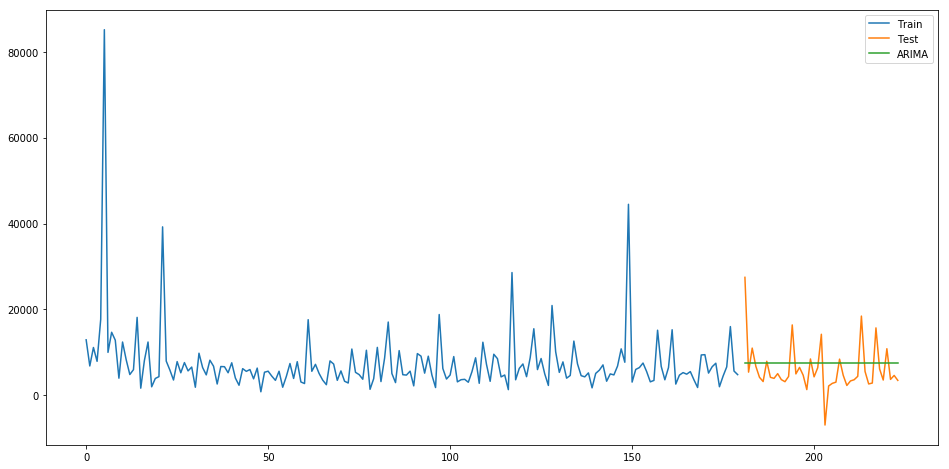

In [14]:
y_arima = test.copy()
y_arima['ARIMA'] = model_arima.forecast(len(test))[0]

rms = sqrt(mean_squared_error(test.TotalSales, y_arima.ARIMA))
print('RMSE Moving Avg for ARIMA:',rms)

plt.figure(figsize=(16,8))
plt.plot( train['TotalSales'], label='Train')
plt.plot(test['TotalSales'], label='Test')
plt.plot(y_arima['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

In [15]:
sub['TotalSales'] = model_arima.forecast(len(sub))[0]
sub.to_csv('submission_arima.csv',index = False)
sub.head()

,InvoiceDate,TotalSales
0,2011-09-08,7420.238117
1,2011-09-09,7420.238117
2,2011-09-11,7420.238117
3,2011-09-12,7420.238117
4,2011-09-13,7420.238117
